Imports

In [5]:
from jax import random
import jax.numpy as jnp
import matplotlib.pyplot as plt
import jax

Random generator

(1000,)


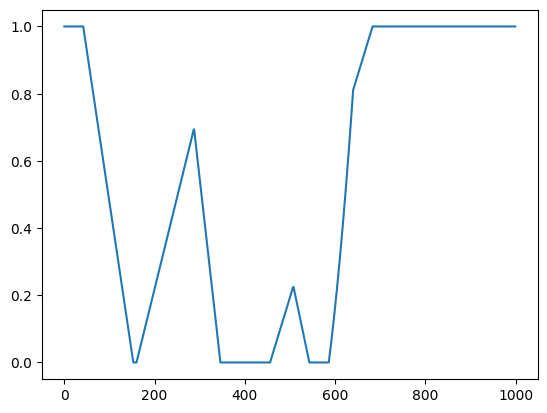

In [6]:
""" 
Calculates an amplifying-function, which can be used to decrease the values of another array with the same length.
An array of shape (time / sampling rate) will be returned, containing values between 0 and 1.
The covariance values are relative to the length of the array that will be created.
"""
def motion_amplifier(
        time,
        sampling_rate,
        key_rigid_phases,
        n_rigid_phases = 3,
        rigid_duration_cov = jnp.array([0.02] * 3),
        transition_cov = jnp.array([0.1] * 3)
        ) -> jnp.ndarray:
    assert rigid_duration_cov.shape == (n_rigid_phases,) == transition_cov.shape, "motion_amplifier: There must be a variance for each rigid phase!"
    n_frames = int(time / sampling_rate)
    key_rigid_means, key_rigid_variances, key_slope_down_variances, key_slope_up_variances = random.split(key_rigid_phases, 4)

    # Calculate center points of rigid phases
    means = jnp.sort(random.uniform(key_rigid_means, shape=(n_rigid_phases, 1), minval=0, maxval=n_frames).T)

    # Calculate durations, which is twice the rigid distance from the center points for each rigid phase.
    rigid_distances = jnp.abs(random.multivariate_normal(key_rigid_variances, mean=jnp.zeros_like(means), cov=jnp.diag((rigid_duration_cov * n_frames)**2)))

    # Calculate transition durations
    transition_slowdown_durations = jnp.abs(random.multivariate_normal(key_slope_down_variances, mean=jnp.zeros_like(means), cov=jnp.diag((transition_cov * n_frames)**2)))
    transition_speedup_durations = jnp.abs(random.multivariate_normal(key_slope_up_variances, mean=jnp.zeros_like(means), cov=jnp.diag((transition_cov * n_frames)**2)))
    
    # Phase start and end points
    rigid_starts = (means - rigid_distances).astype(int).flatten()
    rigid_ends = (means + rigid_distances).astype(int).flatten()
    starts_slowing = (means - rigid_distances - transition_slowdown_durations).astype(int).flatten()
    ends_moving = (means + rigid_distances + transition_speedup_durations).astype(int).flatten()

    # Create masks
    def create_mask(start, end):
        nonlocal n_frames
        return jnp.where(jnp.arange(n_frames) < start, 1, 0) + jnp.where(jnp.arange(n_frames) >= end, 1, 0)
    
    mask = jax.vmap(create_mask)
    rigid_mask = jnp.prod(mask(rigid_starts, rigid_ends), axis=0)
    slowdown_masks = mask(starts_slowing, rigid_starts).astype(float)
    speedup_masks = mask(rigid_ends, ends_moving).astype(float)

    def linsp(mask, start, end, begin_val, carry_fun):
        range = end - start
        true_fun = lambda carry, x: (carry_fun(carry, range), 1 - carry)
        false_fun = lambda carry, x: (carry, x)
        f = lambda carry, x: jax.lax.cond(x == 0, true_fun, false_fun, *(carry, x))
        return jax.lax.scan(f, begin_val, mask)[1]
    
    linsp_desc = jax.vmap(lambda m, s1, s2: linsp(m, s1, s2, 0.0, lambda carry, range: carry + 1/range))
    slowdown_mask = jnp.prod(linsp_desc(slowdown_masks, starts_slowing, rigid_starts), axis=0)
    
    linsp_asc = jax.vmap(lambda m, s1, s2: linsp(m, s1, s2, 1.0, lambda carry, range: carry - 1/range))
    speedup_mask = jnp.prod(linsp_asc(speedup_masks, rigid_ends, ends_moving), axis=0)

    return jnp.min(jnp.stack([rigid_mask, slowdown_mask, speedup_mask]), axis=0)

#result = motion_amplifier(100, 0.1, random.PRNGKey(0))
result = jax.jit(lambda key: motion_amplifier(100, 0.1, key))(random.PRNGKey(3))
print(result.shape)
plt.plot(result)
plt.show() 

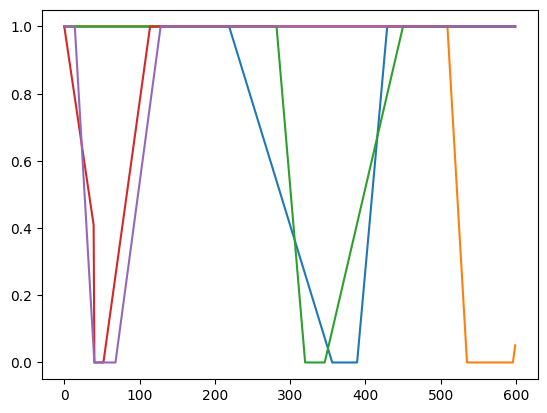

In [6]:
masks = [motion_amplifier(60, 0.1, random.PRNGKey(i), 1, jnp.array([0.02] * 1), jnp.array([0.1] * 1)) for i in range(5)]
for mask in masks:
    plt.plot(mask)
plt.show() 

Fuse with random angles over time

In [ ]:
import x_xy

In [4]:
def raot(s1, s2):
    return x_xy.algorithms.random_angle_over_time(
        key_t=random.PRNGKey(s1),
        key_ang=random.PRNGKey(s2),
        ANG_0=0.0,
        dang_min=0.01,
        dang_max=0.05,
        t_min=0.1,
        t_max=0.5,
        T=100,
        Ts=0.1,
        randomized_interpolation=False,
        range_of_motion=False,
        range_of_motion_method="uniform"
    )


# Generate random angles
qs = raot(0, 1)

# derivate qs
qs_diff = jnp.diff(qs, axis=0)

# mulitply with motion amplifier
qs_diff = qs_diff * result[:-1]

# integrate qs_diff
qs_rigid_phases = jnp.concatenate((qs[0:1], jnp.cumsum(qs_diff, axis=0)))




NameError: name 'result' is not defined

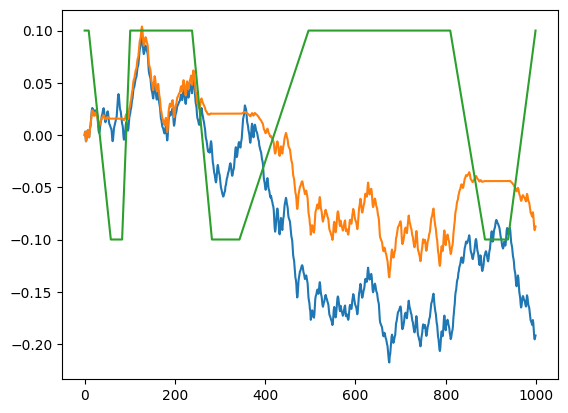

In [ ]:
plt.plot(qs)
plt.plot(qs_rigid_phases)
plt.plot(result * 0.2 - 0.1)
plt.show()

In [5]:
def random_angles_with_rigid_phases_over_time(
                key_t,
                key_ang,
                T,
                Ts,
                key_rigid_phases,
                n_rigid_phases = 3,
                rigid_duration_cov = jnp.array([0.02] * 3),
                transition_cov = jnp.array([0.1] * 3),
                ANG_0=0.0,
                dang_min=0.01,
                dang_max=0.05,
                t_min=0.1,
                t_max=0.5,
                randomized_interpolation=False,
                range_of_motion=False,
                range_of_motion_method="uniform"
        ):
        assert rigid_duration_cov.shape == (n_rigid_phases,) == transition_cov.shape, "motion_amplifier: There must be a variance for each rigid phase!"
        n_frames = int(T / Ts)
        key_rigid_means, key_rigid_variances, key_slope_down_variances, key_slope_up_variances = random.split(key_rigid_phases, 4)

        # Calculate center points of rigid phases
        means = jnp.sort(random.uniform(key_rigid_means, shape=(n_rigid_phases, 1), minval=0, maxval=n_frames).T)

        # Calculate durations, which is twice the rigid distance from the center points for each rigid phase.
        rigid_distances = jnp.abs(random.multivariate_normal(key_rigid_variances, mean=jnp.zeros_like(means), cov=jnp.diag((rigid_duration_cov * n_frames)**2)))

        # Calculate transition durations
        transition_slowdown_durations = jnp.abs(random.multivariate_normal(key_slope_down_variances, mean=jnp.zeros_like(means), cov=jnp.diag((transition_cov * n_frames)**2)))
        transition_speedup_durations = jnp.abs(random.multivariate_normal(key_slope_up_variances, mean=jnp.zeros_like(means), cov=jnp.diag((transition_cov * n_frames)**2)))

        # Create result array
        result = jnp.ones(n_frames) # todo: maybe call random generator here
        transition_starts_slowing = (means - rigid_distances - transition_slowdown_durations).astype(int)
        rigid_starts = (means - rigid_distances).astype(int)
        rigid_ends = (means + rigid_distances).astype(int)
        transition_ends_moving = (means + rigid_distances + transition_speedup_durations).astype(int)
        
        phases = jnp.stack([transition_starts_slowing, rigid_starts, rigid_ends, transition_ends_moving])[:, 0].T
        
        # Assure that all phases are in boundaries
        phases = jnp.where(phases < 0, 0, phases)
        phases = jnp.where(phases >= n_frames, n_frames-1, phases)
        
        for i in range(phases.shape[0]):
                result = result.at[phases[i, 0]:phases[i, 1]].set(jnp.linspace(1, 0, phases[i, 1] - phases[i, 0] + 2)[1:-1])
                result = result.at[phases[i, 1]:phases[i, 2]].set(0)
                result = result.at[phases[i, 2]:phases[i, 3]].set(jnp.linspace(0, 1, phases[i, 3] - phases[i, 2] + 2)[1:-1])


        
        qs = x_xy.random_angle_over_time(
                key_t,
                key_ang,
                ANG_0,
                dang_min,
                dang_max,
                t_min,
                t_max,
                T,
                Ts,
                randomized_interpolation,
                range_of_motion,
                range_of_motion_method
        )       

        # derivate qs
        qs_diff = jnp.diff(qs, axis=0)

        # mulitply with motion amplifier
        qs_diff = qs_diff * result[:-1]

        # integrate qs_diff
        qs_rigid_phases = jnp.concatenate((qs[0:1], jnp.cumsum(qs_diff, axis=0)))




Define wrapper function with extended Config

In [6]:
import x_xy
import jax
from dataclasses import dataclass
import jax.numpy as jnp

@dataclass
class ExtendedConfig(x_xy.algorithms.RCMG_Config):
    n_rigid_phases : int = 3
    cov_rigid_durations : jax.Array = jnp.array([0.02] * n_rigid_phases)
    cov_transitions : jax.Array = jnp.array([0.1] * n_rigid_phases)

    def __post_init__(self):
        assert self.cov_rigid_durations.shape == self.cov_transitions.shape

def a():
    @jax.jit
    def b(a, b):
        return a + b 
    return b

def _draw_sometimes_rigid(
        config: ExtendedConfig, key_t: jax.random.PRNGKey, key_value: jax.random.PRNGKey
        
) -> jax.Array:
    key_t, key_rigid_phases = jax.random.split(key_t)

    return random_angles_with_rigid_phases_over_time(
        key_t=key_t,
        key_ang=key_value,
        T=config.T,
        Ts=config.Ts,
        key_rigid_phases=key_rigid_phases,
        n_rigid_phases=config.n_rigid_phases,
        rigid_duration_cov=config.cov_rigid_durations,
        transition_cov=config.cov_transitions,
        ANG_0=0,
        dang_min=config.dang_min,
        dang_max=config.dang_max,
        t_min=config.t_min,
        t_max=config.t_max,
        randomized_interpolation=config.randomized_interpolation,
        range_of_motion=config.range_of_motion,
        range_of_motion_method=config.range_of_motion_method
    )

Defining a new angle

In [7]:
import jax
import x_xy
from dataclasses import dataclass

three_seg_seg2 = r"""
<x_xy model="three_seg_seg2">
    <options gravity="0 0 9.81" dt="0.01"/>
    <worldbody>
        <body name="seg2" joint="rsrx">
            <body name="seg1" joint="rsrx">
                <body name="imu1" joint="frozen"/>
            </body>
            <body name="seg3" joint="rsrx">
                <body name="imu2" joint="frozen"/>
            </body>
        </body>
    </worldbody>
</x_xy>
"""


rsrx_joint = x_xy.algorithms.JointModel(
    lambda q, _: x_xy.algorithms._rxyz_transform(q, _, jnp.array([1.0, 0, 0])), [None], rcmg_draw_fn=_draw_sometimes_rigid
)
rsry_joint = x_xy.algorithms.JointModel(
    lambda q, _: x_xy.algorithms._rxyz_transform(q, _, jnp.array([0, 1.0, 0])), [None], rcmg_draw_fn=_draw_sometimes_rigid
)
rsrz_joint = x_xy.algorithms.JointModel(
    lambda q, _: x_xy.algorithms._rxyz_transform(q, _, jnp.array([0, 0, 1.0])), [None], rcmg_draw_fn=_draw_sometimes_rigid
)
x_xy.algorithms.register_new_joint_type("rsrx", rsrx_joint, 1)
x_xy.algorithms.register_new_joint_type("rsry", rsry_joint, 1)
x_xy.algorithms.register_new_joint_type("rsrz", rsrz_joint, 1)


# by default `joint_params` gets initialized to zeros
# so replace with desired joint axes during setup of the
# system

@jax.vmap
def draw_random_joint_axis(key):
    J = jax.random.uniform(key, (3,), minval=-1.0, maxval=1.0)
    Jnorm = jax.numpy.linalg.norm(J)
    return J / Jnorm

def setup_fn(sys: x_xy.base.System) -> x_xy.base.System:

    def replace_params(joint_params, new_params, name: str):
        i = sys.name_to_idx(name)
        # print(joint_params.at[i])
        return joint_params.at[i].set(new_params)

    # randomize joint axes
    joint_axes = draw_random_joint_axis(jax.random.split(jax.random.PRNGKey(0)))
    joint_params = sys.links.joint_params
    joint_params = replace_params(joint_params, joint_axes[0], "seg1")
    joint_params = replace_params(joint_params, joint_axes[1], "seg3")

    return sys.replace(
        links=sys.links.replace(joint_params=joint_params)
    )


 #   from_xml(three_seg_seg2)

In [8]:
system = x_xy.io.load_sys_from_str(three_seg_seg2)
setup_fn(system)

System(link_parents=[-1, 0, 1, 0, 3], links=Link(transform1=Transform(pos=Array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]], dtype=float32), rot=Array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]], dtype=float32)), joint_params=Array([[ 0.        ,  0.        ,  0.        ],
       [ 0.19302757,  0.6803956 , -0.70696694],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.63899887, -0.66736853, -0.38249138],
       [ 0.        ,  0.        ,  0.        ]], dtype=float32), inertia=Inertia(it_3x3=Array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32), h=Array(

In [9]:
T: float = 60.0  # length of random motion
Ts: float = 0.01  # sampling rate
t_min: float = 0.15  # min time between two generated angles
t_max: float = 0.75  # max time ..

dang_min: float = float(jnp.deg2rad(0))  # minimum angular velocity in deg/s
dang_max: float = float(jnp.deg2rad(120))  # maximum angular velocity in deg/s

# minimum angular velocity of euler angles used for `free and spherical joints`
dang_min_free: float = float(jnp.deg2rad(0))
dang_max_free: float = float(jnp.deg2rad(60))

dpos_min: float = 0.001  # speed of translation
dpos_max: float = 0.1
pos_min: float = -2.5
pos_max: float = +2.5

# flags
randomized_interpolation: bool = False
range_of_motion_hinge: bool = True
range_of_motion_hinge_method: str = "uniform"

# rigid phases
n_rigid_phases = 3
cov_rigid_durations =  jnp.array([0.02] * 3)
cov_transitions = jnp.array([0.1] * 3)

cfg = ExtendedConfig(
    T, Ts, t_min, t_max, dang_min, dang_max, dang_min_free, dang_max_free,
    dpos_min, dpos_max, pos_min, pos_max, randomized_interpolation, range_of_motion_hinge,
    range_of_motion_hinge_method, n_rigid_phases, cov_rigid_durations, cov_transitions
    )

system = x_xy.io.load_sys_from_str(three_seg_seg2)
#setup_fn(system)

x_xy.algorithms.build_generator(system, cfg)

<function x_xy.algorithms.rcmg.build_generator.<locals>.generator(key: <function PRNGKey at 0x7ffa5fa2e170>) -> dict>

# Plot examples for runs

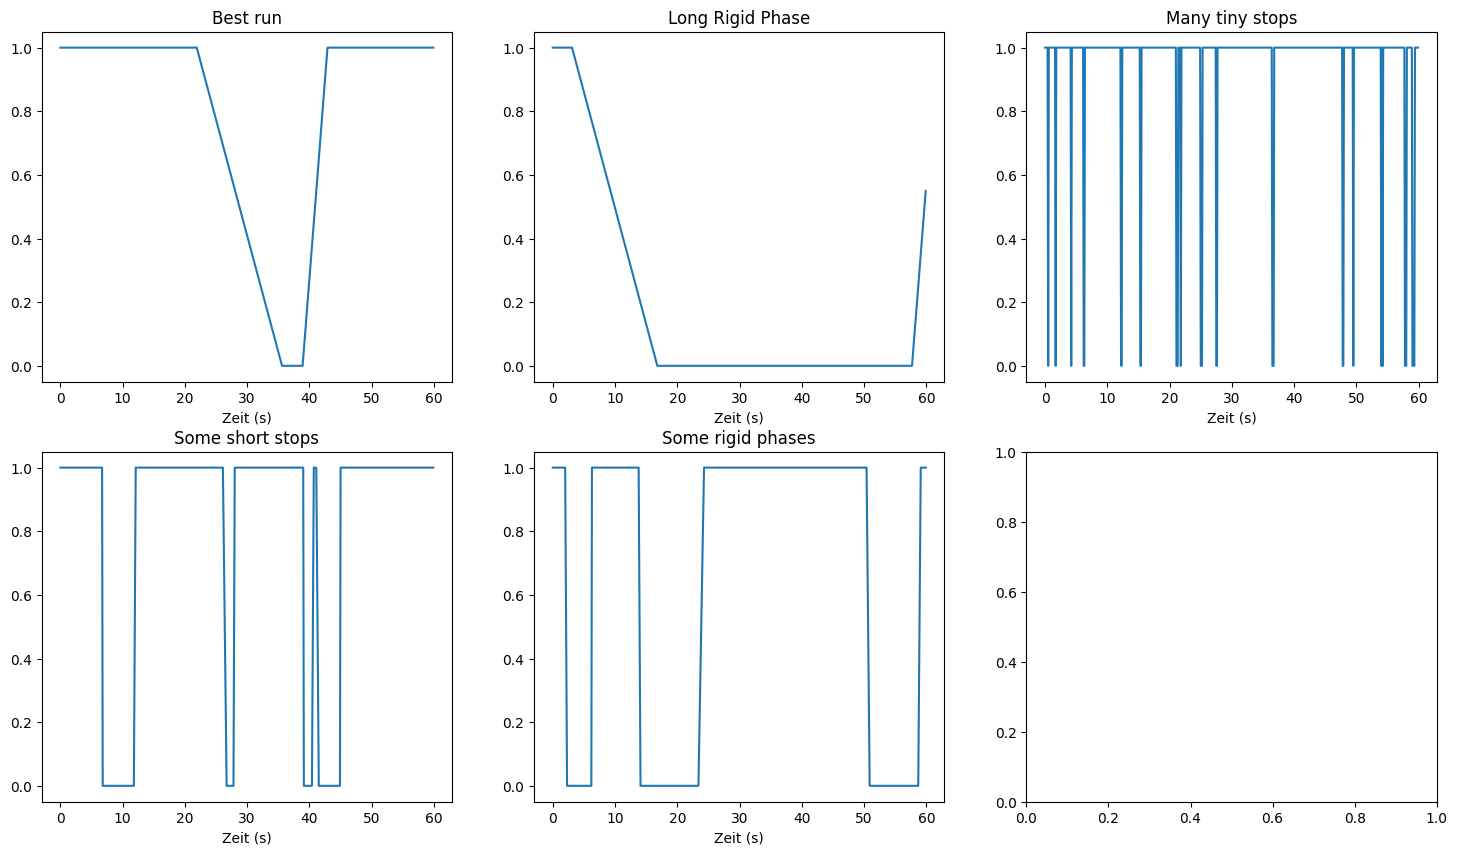

In [56]:
import matplotlib.pyplot as plt
from jax.random import PRNGKey
import jax.numpy as jnp
ROWS, COLS = 2, 3
T, TS = 60, 0.1
KEY = PRNGKey(0)
fig, axes = plt.subplots(nrows=ROWS, ncols=COLS, figsize=(18, 10))
amplify_fun = lambda n_phases, rigid_cov, transistion_cov: motion_amplifier(
    T, TS, KEY, n_phases, jnp.array([rigid_cov] * n_phases), jnp.array([transistion_cov] * n_phases)
    )

data = [
    amplify_fun(1, 0.02, 0.1),
    amplify_fun(1, 0.25, 0.1),
    amplify_fun(30, 0.001, 0.0001),
    amplify_fun(5, 0.02, 0.005),
    amplify_fun(3, 0.05, 0.01)
]
titles = [
    "Best run",
    "Long Rigid Phase",
    "Many tiny stops",
    "Some short stops",
    "Some rigid phases"
]

row, col = 0, 0
for date, title in zip(data, titles):
    x = jnp.arange(len(date)) * TS
    axes[row, col].plot(x, date)
    axes[row, col].set_title(title)
    axes[row, col].set_xlabel("Zeit (s)")
    col += 1
    if (col == COLS):
        col = 0
        row += 1
    if row >= ROWS:
        print("not enough space")
        break